# In-Depth Exploratory Data Analysis (EDA) of Netflix Content

**Project Objective:** To perform an in-depth exploratory data analysis of the Netflix dataset. We will explore trends in content production, identify popular genres, analyze content ratings, and understand the distribution of movies and TV shows on the platform. This project builds on foundational EDA by introducing time-series analysis and more complex data cleaning and transformation techniques.

### Core Concepts We'll Cover:
1.  **Data Cleaning & Transformation:** Handling missing values and converting data types (especially dates).
2.  **Time-Series Analysis:** Analyzing how content has been added to Netflix over the years.
3.  **Text Data Manipulation:** Parsing and analyzing columns with multiple values, like `listed_in` (genres) and `cast`.
4.  **Geographical & Rating Analysis:** Understanding where content comes from and its maturity level.
5.  **Feature Engineering:** Creating new, insightful features like 'content age'.
6.  **Advanced Visualization:** Creating insightful plots to understand distributions and relationships in the data.

### Setup - Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set a consistent style for our plots
sns.set_style('darkgrid')

### Data Loading and Initial Inspection

In [4]:
df = pd.read_csv("21-Days-21-Projects-Dataset/Datasets/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [5]:
df.shape

(7787, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


**Interpretation of `.info()`:**
- 7,787 entries in the dataset.
- `date_added` is a string, not a datetime.
- Missing values in `director`, `cast`, `country`, `date_added`, and `rating`.
- `director` has the most missing values.

In [7]:
df.describe()

,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


### Data Cleaning and Transformation

In [8]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

**1. Handle missing values in 'director' and 'cast'**

In [9]:
# Many are missing -> fill them with 'Unknown'.
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')

In [10]:
df.isnull().sum()

show_id           0
type              0
title             0
director          0
cast              0
country         507
date_added       10
release_year      0
rating            7
duration          0
listed_in         0
description       0
dtype: int64

**2. Handle missing 'country'**

In [12]:
df['country'].value_counts()

country
United States                                     2555
India                                              923
United Kingdom                                     397
Japan                                              226
South Korea                                        183
                                                  ... 
Germany, United States, United Kingdom, Canada       1
Peru, United States, United Kingdom                  1
Saudi Arabia, United Arab Emirates                   1
United Kingdom, France, United States, Belgium       1
France, Norway, Lebanon, Belgium                     1
Name: count, Length: 681, dtype: int64

In [13]:
# Fill with the mode -> most common country.
df['country'] = df['country'].fillna(df['country'].mode()[0])

**3. Drop the few rows with missing 'date_added' and 'rating'**

In [14]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

(Since the number of missing values in 'date_added' and 'rating' is small ( >0.2% ), dropping these rows won't affect the data much)

In [15]:
df.dropna(subset=['date_added', 'rating'], inplace=True)

In [16]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

**4. Convert 'date_added' to datetime objects**

In [17]:
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', dayfirst=True)

**5. Create new features for year and month added**

In [18]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

In [19]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 0 to 7786
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       7770 non-null   object        
 1   type          7770 non-null   object        
 2   title         7770 non-null   object        
 3   director      7770 non-null   object        
 4   cast          7770 non-null   object        
 5   country       7770 non-null   object        
 6   date_added    7770 non-null   datetime64[ns]
 7   release_year  7770 non-null   int64         
 8   rating        7770 non-null   object        
 9   duration      7770 non-null   object        
 10  listed_in     7770 non-null   object        
 11  description   7770 non-null   object        
 12  year_added    7770 non-null   int32         
 13  month_added   7770 non-null   int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(10)
memory usage: 849.8+ KB


In [21]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

### Exploratory Data Analysis & Visualization

**1. What is the distribution of content type?**

In [23]:
df['type'].value_counts()

type
Movie      5372
TV Show    2398
Name: count, dtype: int64

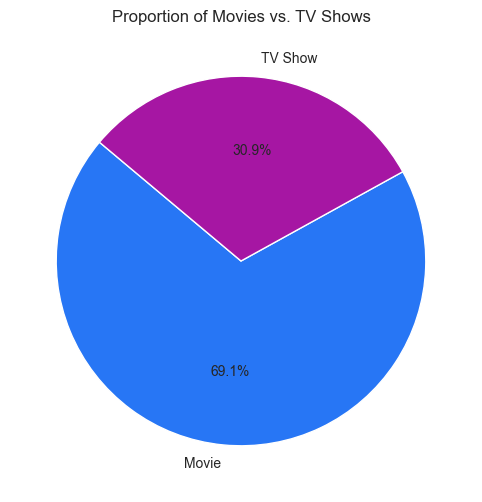

In [24]:
plt.figure(figsize=(8,6))
type_counts = df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#2776F5', '#A616A3'])
plt.title('Proportion of Movies vs. TV Shows')
plt.ylabel('')
plt.show()

**Insight:** The Netflix library is dominated by **Movies**, which account for approximately **70%** of the content in the dataset.

**2. How has content been added over time?**

<Figure size 1400x800 with 0 Axes>

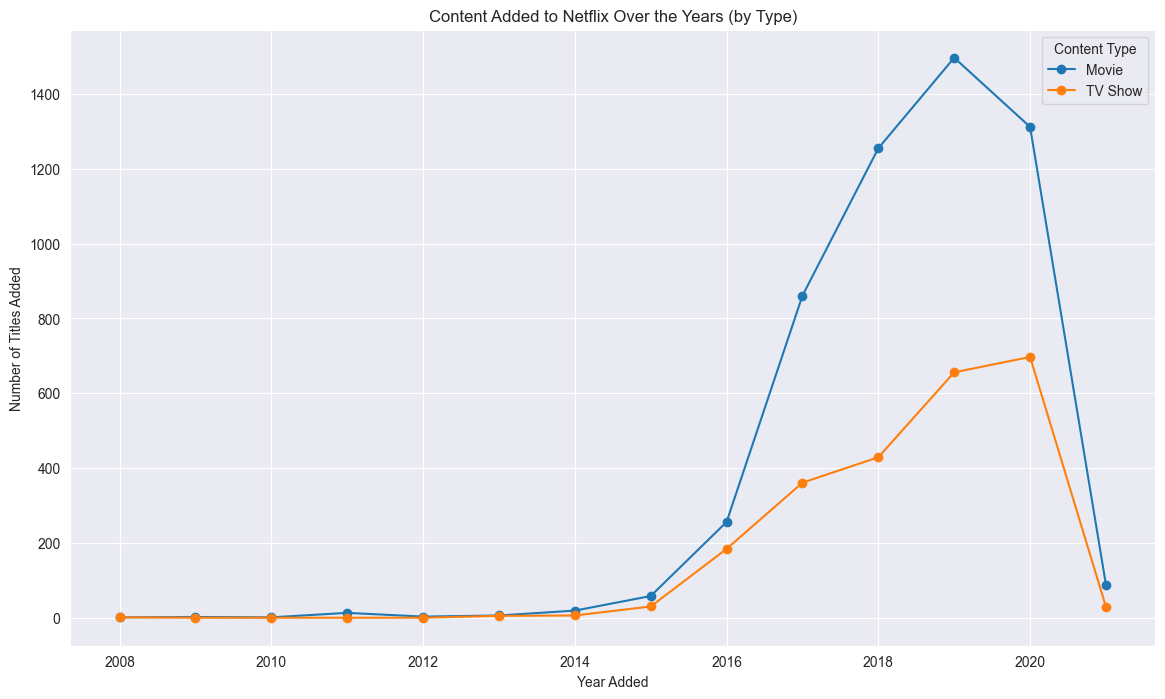

In [25]:
content_over_time = df.groupby(['year_added','type']).size().unstack().fillna(0)

plt.figure(figsize=(14, 8))
content_over_time.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Content Added to Netflix Over the Years (by Type)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

**Insight:** Separating Movies and TV Shows reveals that both saw growth over time, but movie additions accelerated sharply, peaking in **2019**. TV show growth has been more consistent. A slight slowdown in **2020** and **2021** may reflect the impact of the **COVID-19 pandemic** on production or incomplete data for recent years.

**3. What are the most popular genres?**

In [26]:
df['listed_in'].value_counts()

listed_in
Documentaries                                                334
Stand-Up Comedy                                              321
Dramas, International Movies                                 320
Comedies, Dramas, International Movies                       243
Dramas, Independent Movies, International Movies             215
                                                            ... 
Sports Movies                                                  1
Crime TV Shows, TV Horror, TV Mysteries                        1
Children & Family Movies, Classic Movies, Dramas               1
Romantic TV Shows, Spanish-Language TV Shows, TV Comedies      1
Dramas, Faith & Spirituality, Sports Movies                    1
Name: count, Length: 491, dtype: int64

In [27]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1


**Observation:** The `listed_in` column contains multiple genres as a single string.

**Plan:**
- Split the genre strings into separate items.
- Use `df.explode()` to create a new row for each genre, so each title appears once per genre.


In [28]:
df['listed_in'].str.split(', ')

0       [International TV Shows, TV Dramas, TV Sci-Fi ...
1                          [Dramas, International Movies]
2                   [Horror Movies, International Movies]
3       [Action & Adventure, Independent Movies, Sci-F...
4                                                [Dramas]
                              ...                        
7782                       [Dramas, International Movies]
7783     [Dramas, International Movies, Music & Musicals]
7784    [Documentaries, International Movies, Music & ...
7785                 [International TV Shows, Reality TV]
7786                    [Documentaries, Music & Musicals]
Name: listed_in, Length: 7770, dtype: object

In [31]:
# Split the 'listed_in' column and explode it
genres = df.assign(genre=df['listed_in'].str.split(', ')).explode('genre')

In [32]:
# Get the top 15 genres and their counts
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['genre', 'count'] # Rename columns for clarity

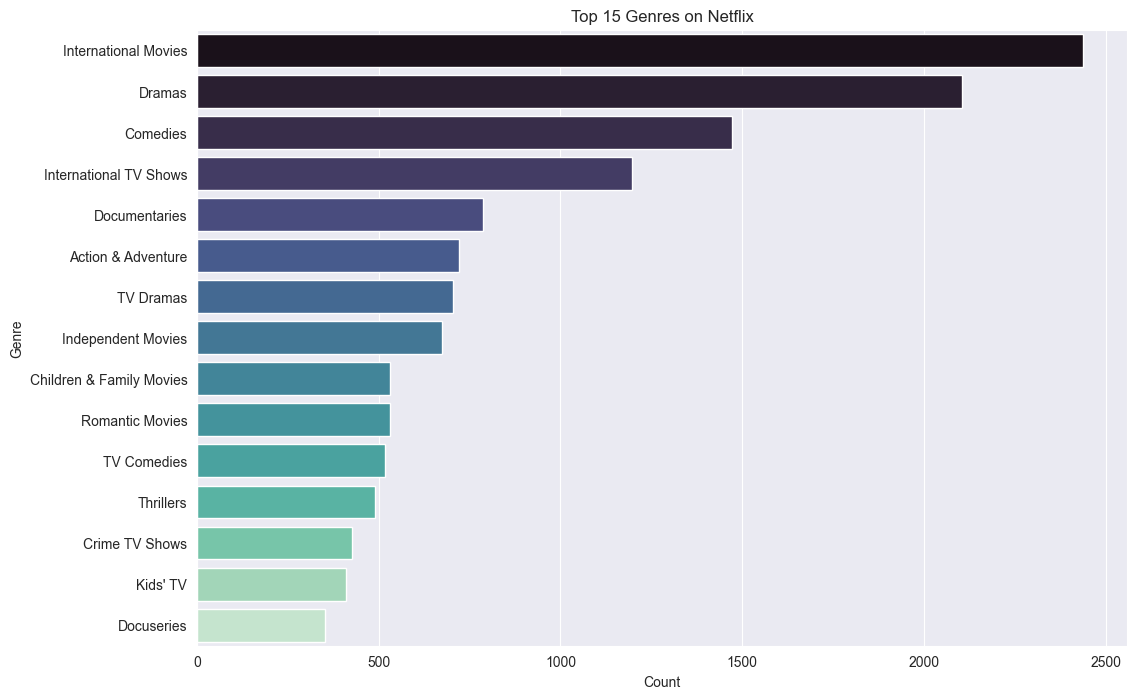

In [33]:
# Select only the top 15 for plotting
top_genres_counts_plot = top_genres_counts.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y='genre', x='count', data=top_genres_counts_plot, palette='mako', hue='genre', legend=False)
plt.title('Top 15 Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

**Insight:** "International Movies" is the most common genre tag, reflecting Netflix's global content strategy. It is followed by **Dramas**, **Comedies**, and **Action & Adventure**.


**4. What is the distribution of content duration?**

In [34]:
# Separate movies and TV shows
movies_df = df[df['type'] == 'Movie'].copy()
tv_shows_df = df[df['type'] == 'TV Show'].copy()

In [35]:
# Clean and convert duration for movies
movies_df['duration_min'] = movies_df['duration'].str.replace(' min', '').astype(int)

# Clean and convert duration for TV shows
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)

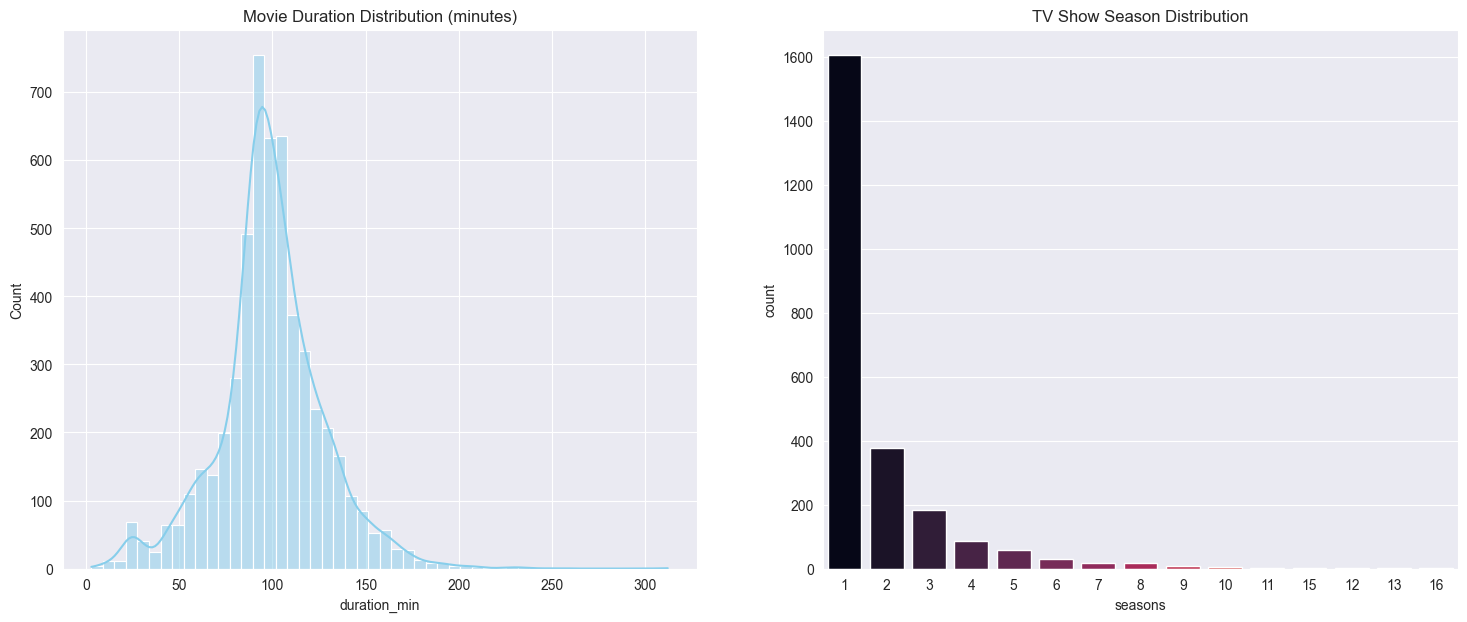

In [36]:
# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Movie Duration Distribution
sns.histplot(ax=axes[0], data=movies_df, x='duration_min', bins=50, kde=True, color='skyblue').set_title('Movie Duration Distribution (minutes)')

# TV Show Season Distribution
sns.countplot(ax=axes[1], x='seasons', data=tv_shows_df, palette='rocket', order=tv_shows_df['seasons'].value_counts().index, hue='seasons', legend=False).set_title('TV Show Season Distribution')

plt.show()

**Insight:**

- Most **movies** on Netflix are between **80 and 120 minutes**, aligning with typical feature film lengths.
- The majority of **TV shows** have only **1 season**, suggesting a strategy focused on limited series or testing shows before committing to longer runs.


**5. Where does the content come from? (Geographical Analysis)**

In [39]:
df['country'].value_counts()

country
United States                                     3051
India                                              923
United Kingdom                                     396
Japan                                              224
South Korea                                        183
                                                  ... 
Germany, United States, United Kingdom, Canada       1
Peru, United States, United Kingdom                  1
Saudi Arabia, United Arab Emirates                   1
United Kingdom, France, United States, Belgium       1
France, Norway, Lebanon, Belgium                     1
Name: count, Length: 681, dtype: int64

In [38]:
# Handle the multi-country listings similar to genres
countries = df.assign(country=df['country'].str.split(', ')).explode('country')

In [40]:
# Get the top 15 countries and their counts
top_countries_counts = countries['country'].value_counts().reset_index()
top_countries_counts.columns = ['country', 'count'] # Rename columns for clarity

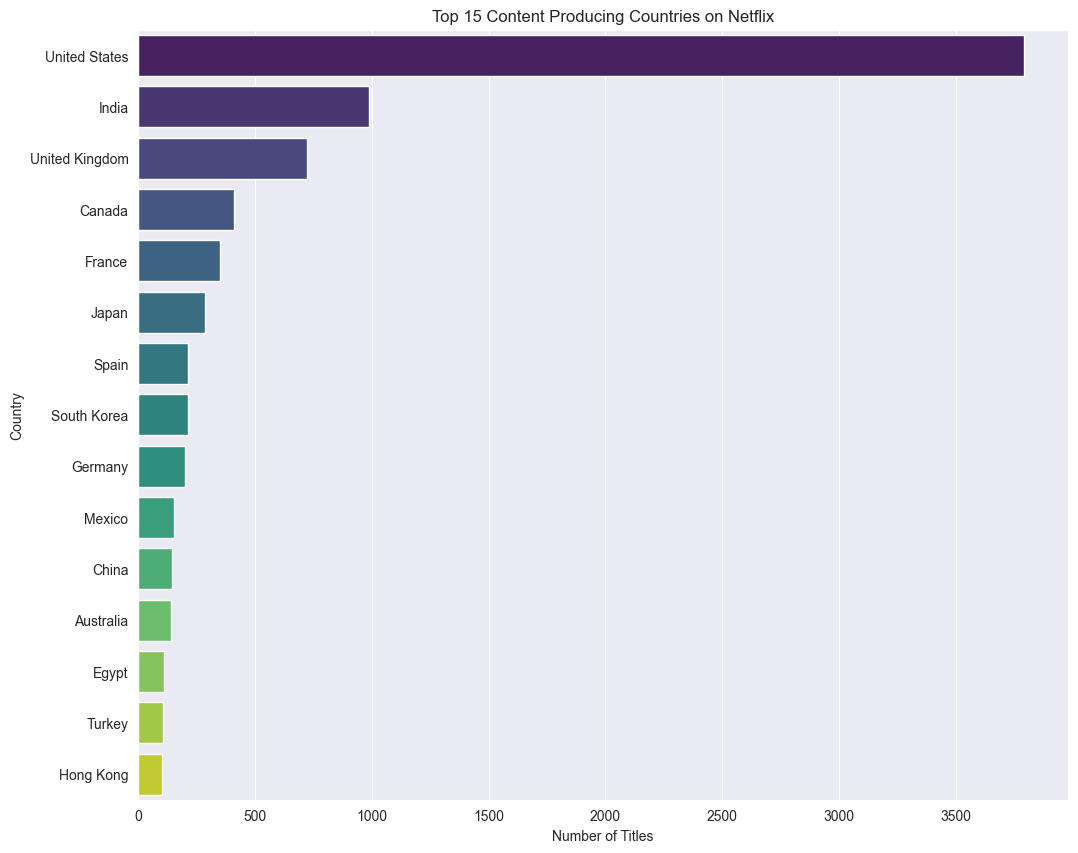

In [41]:
# Select only the top 15 for plotting
top_countries_counts_plot = top_countries_counts.head(15)

plt.figure(figsize=(12, 10))
sns.barplot(y='country', x='count', data=top_countries_counts_plot, palette='viridis', hue='country', legend=False)
plt.title('Top 15 Content Producing Countries on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

**Insight:**  
The **United States** is by far the largest producer of content on Netflix. However, **India** is a strong second, which explains the high number of top actors from India. Other major content-producing countries include the **UK**, **Japan**, and **South Korea**, highlighting Netflix’s global reach and diverse catalog.


**6. What are the maturity ratings of the content?**

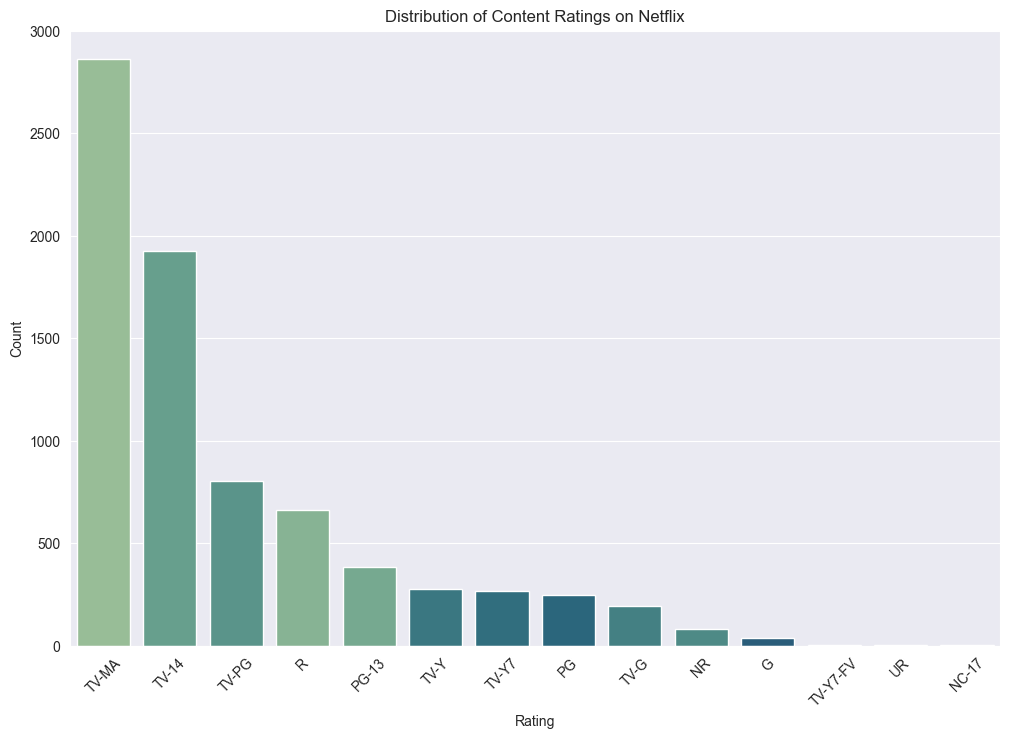

In [42]:
plt.figure(figsize=(12, 8))
sns.countplot(x='rating', data=df, order=df['rating'].value_counts().index, palette='crest', hue='rating', legend=False)
plt.title('Distribution of Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Insight:**  
A significant portion of Netflix's content targets **mature audiences**, with **TV-MA** and **TV-14** being the most common ratings. This indicates a strategic focus on adult viewers, rather than on children's programming like **TV-G** or **TV-Y**.


### Feature Engineering - Content Freshness

Create a new feature to measure how old a title is when it’s added to Netflix. 
This helps analyze Netflix’s **content acquisition strategy**


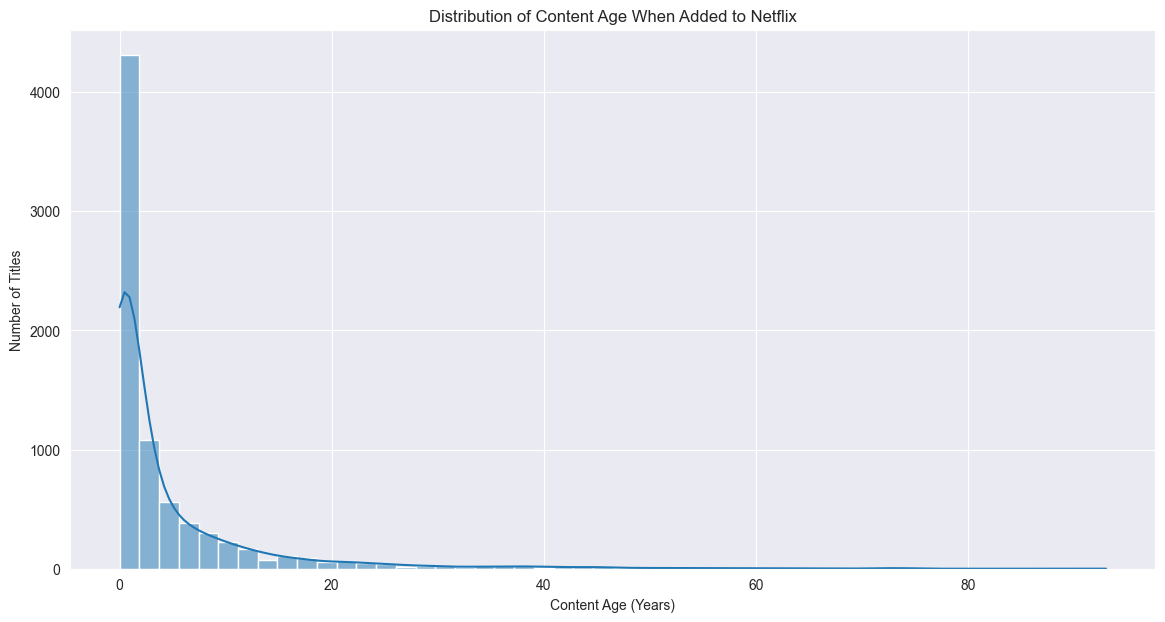

In [43]:
# Create the 'age_on_netflix' feature
df['age_on_netflix'] = df['year_added'] - df['release_year']
content_age = df[df['age_on_netflix'] >= 0]

plt.figure(figsize=(14, 7))
sns.histplot(data=content_age, x='age_on_netflix', bins=50, kde=True)
plt.title('Distribution of Content Age When Added to Netflix')
plt.xlabel('Content Age (Years)')
plt.ylabel('Number of Titles')
plt.show()

**Insight:**  
The large spike at **0** suggests that a significant portion of content is added to Netflix in the **same year it's released**, typical of **Netflix Originals**. However, the long tail indicates that Netflix also invests heavily in **licensed content**, including titles that are **decades old**, helping to build a rich library of classic films and shows.


### Deeper Multivariate Analysis

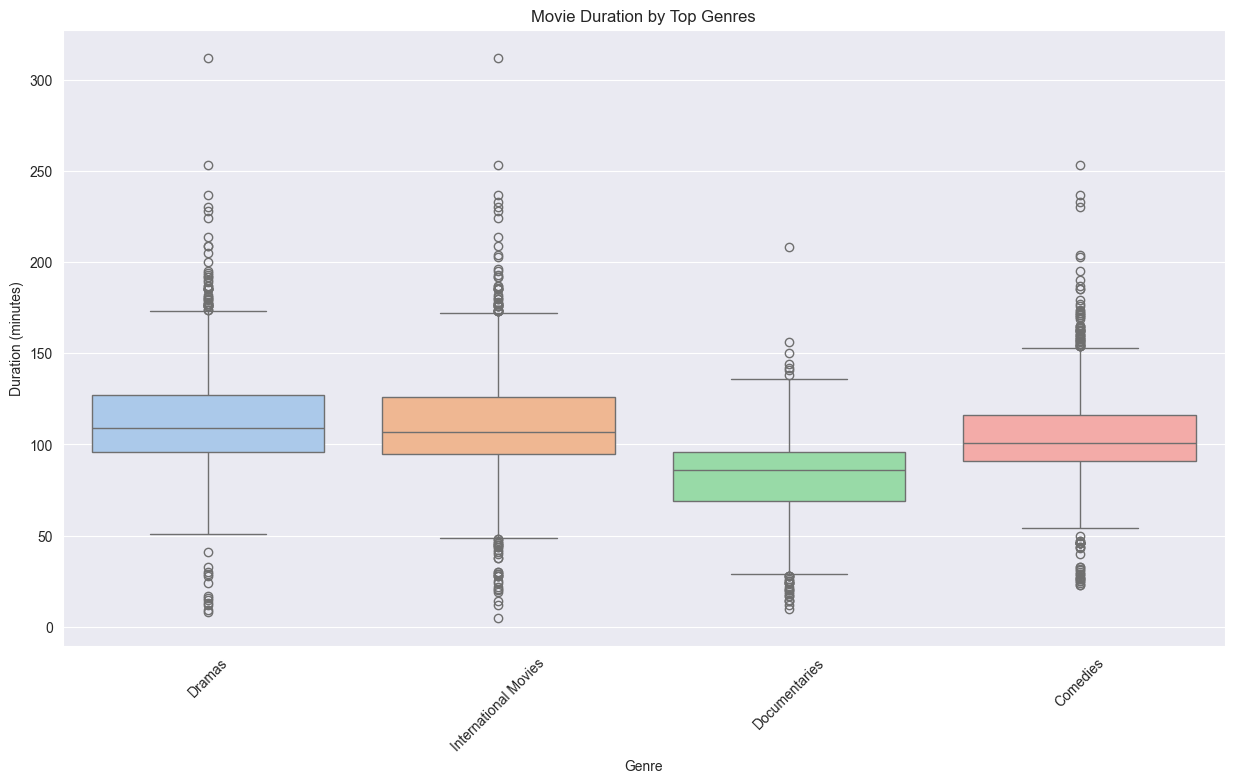

In [46]:
# Analyze movie duration across different top genres
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(15, 8))
sns.boxplot(data=genres_movies, x='genre', y='duration_min', palette='pastel', hue='genre', legend=False)
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()

**Insight:**

- Most top genres have a median duration of **90–100 minutes**.
- **Dramas** tend to have a **wider range** of durations, with many longer films.
- **International Movies** show a **broad distribution**, reflecting **diverse global filmmaking styles**.


### Word Cloud from Content Descriptions
Generate a word cloud from the `description` column to see what themes and words are most common in Netflix content.

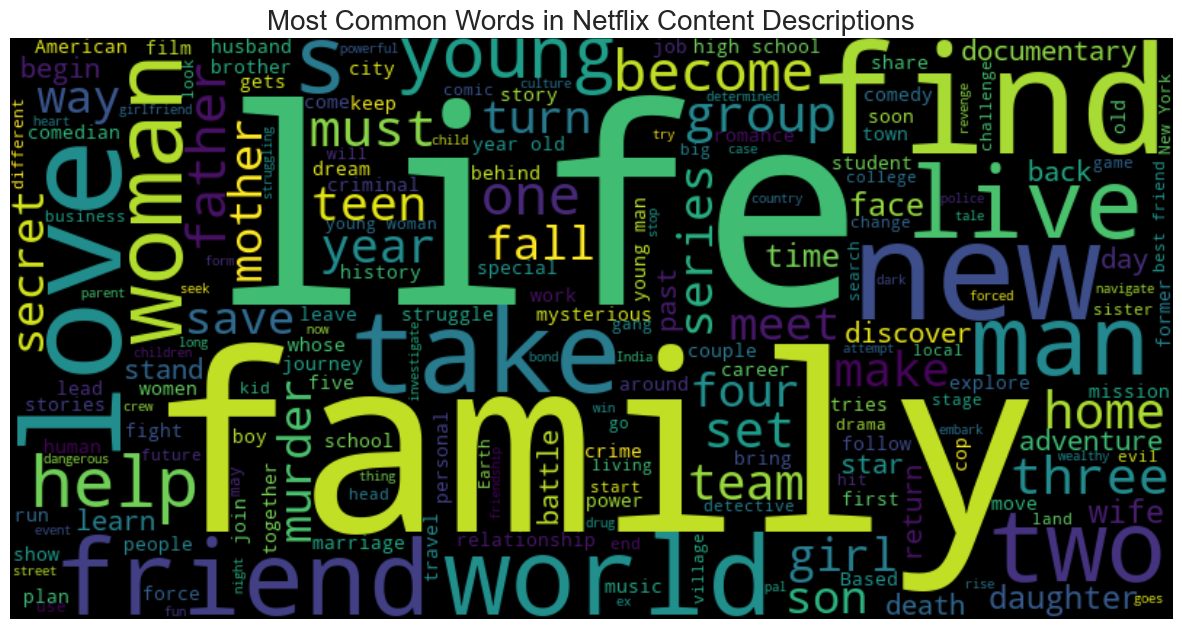

In [48]:
# Combine all descriptions into a single string
text = ' '.join(df['description'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions', fontsize=20)
plt.show()

**Insight:**

- The word cloud highlights common themes and subjects in Netflix content.
- Prominent words like **"life," "family," "love," "young," "friends,"** and **"world"** suggest a strong focus on **human relationships** and **personal journeys**.
- Action-oriented words such as **"find," "secret,"** and **"new"** also appear frequently, hinting at themes of **adventure**, **mystery**, and **discovery**.


### Final Conclusion and Summary of Insights

This in-depth EDA of the Netflix dataset has revealed several key characteristics and strategies of the platform's content library.

**Key Findings:**

1. **Content Strategy:**  
   Netflix’s library is heavily weighted toward **movies** (~70%). The platform saw aggressive content growth between **2016–2019**, driven by a mix of **new originals** (often added the same year they're released) and a deep catalog of **older licensed content**.

2. **Global Dominance:**  
   While the **U.S.** is the top content producer, Netflix has a strong **international focus**. **India** is a major contributor, which is reflected in popular genres like **"International Movies"** and the high frequency of Indian actors.

3. **Target Audience:**  
   The content skews toward **mature viewers**, with **TV-MA** and **TV-14** being the most common ratings, indicating a focus on adult-oriented programming over children's content.

4. **Content Format & Genre:**  
   **Dramas** and **Comedies** are the most prevalent genres. Most movies fall within the standard **90–120 minute** duration. The majority of TV shows have only **one season**, suggesting a strategy focused on **limited series** or **testing concepts** before longer commitments.

5. **Common Themes:**  
   Content descriptions frequently feature universal themes such as **life**, **family**, **love**, and **discovery**, alongside action-driven elements like **"find"**, **"secret"**, and **"new"**.

---

## **Limitations:**

- This dataset represents a **snapshot in time** and does **not include viewership data**.
- As such, the analysis reflects the **supply of content**, not its **demand or popularity**.
- Despite this, the EDA offers a well-rounded view of Netflix’s **content composition** and **evolution**.


# Submission Q's

**1. How has the distribution of content ratings changed over time?**

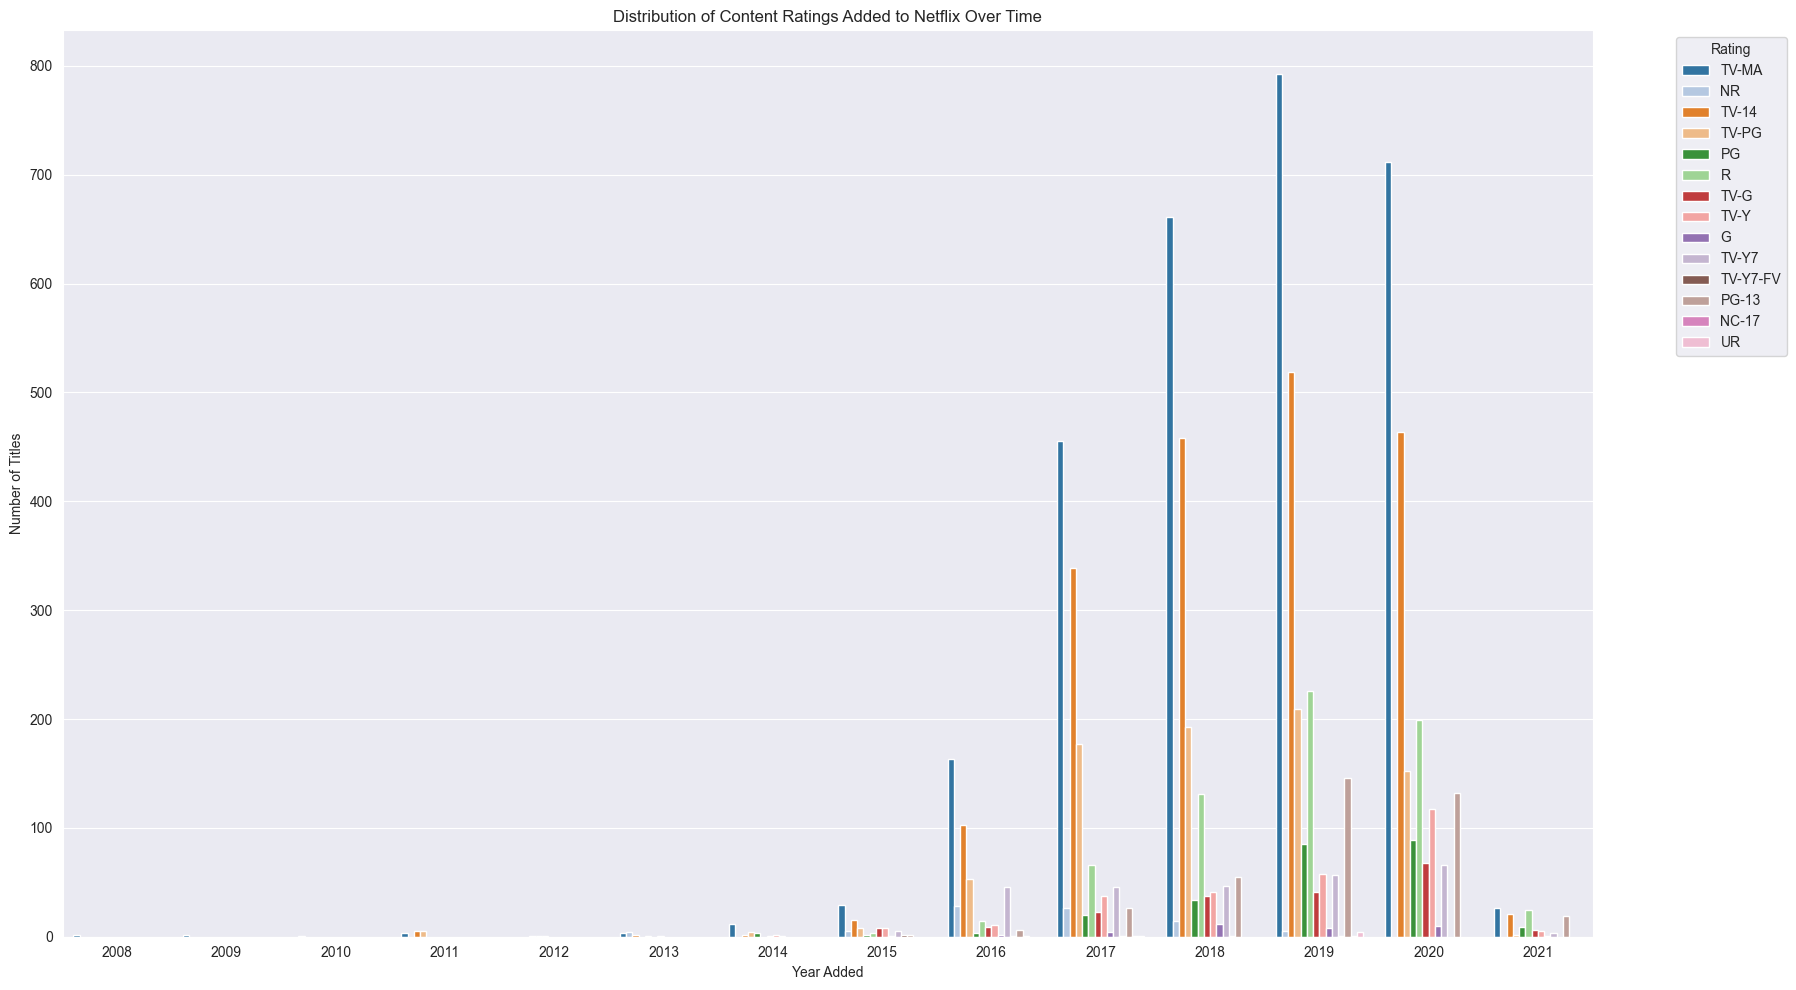

In [50]:
plt.figure(figsize=(18, 10))
sns.countplot(data=df, x='year_added', hue='rating', order=sorted(df['year_added'].dropna().unique()), palette='tab20')
plt.title('Distribution of Content Ratings Added to Netflix Over Time')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [51]:
# Display TV series with rating 'R' (if any)
tv_shows_r = tv_shows_df[tv_shows_df['rating'] == 'R']
tv_shows_r

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,seasons
4497,s4498,TV Show,Nobel,Unknown,"Aksel Hennie, Tuva Novotny, Anders Danielsen L...",Norway,2016-12-10,2016,R,1 Season,"International TV Shows, TV Dramas, TV Thrillers",A series of incidents in Afghanistan set compl...,2016,12,1
6435,s6436,TV Show,The Hateful Eight: Extended Version,Quentin Tarantino,"Samuel L. Jackson, Kurt Russell, Jennifer Jaso...",United States,2019-04-25,2015,R,1 Season,TV Shows,Trapped at a stagecoach stop as a storm rages ...,2019,4,1


**Insight:**

- There has been a steady increase in **Mature content (TV-MA)** added over the years.
- For most years (except 2011–2013), Netflix added more **TV-MA rated movies** than any other rating.
- A similar pattern is seen in series, though between **2015 and 2017**, more **TV-14** series were added than TV-MA.
- Only **two series rated R** were added, one each in **2015** and **2016**.


**2. Is there a relationship between content age and its type (Movie vs. TV Show)?**

In [53]:
content_age.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,age_on_netflix
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,0


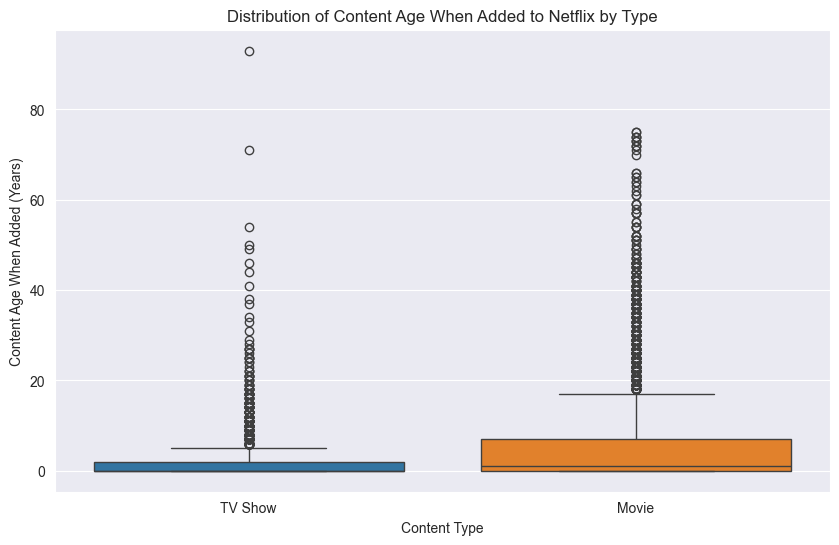

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=content_age, x='type', y='age_on_netflix', hue='type')
plt.title('Distribution of Content Age When Added to Netflix by Type')
plt.xlabel('Content Type')
plt.ylabel('Content Age When Added (Years)')
plt.show()

**Insights:**

- Netflix primarily adds newer shows and movies.
- Most **movies** are between **0 to 10 years old** when added.
- Most **TV shows** are between **0 to 5 years old** when added.
- Some titles don’t follow this trend:
  - TV shows cover a **wider age range** than movies, with the oldest being over **80 years old**.
  - However, fewer TV shows fall outside the typical age range compared to movies.
- Overall, Netflix is **more likely to add older movies** than older TV shows.


**3. Can we identify any trends in content production based on the release year vs. the year added to Netflix?**

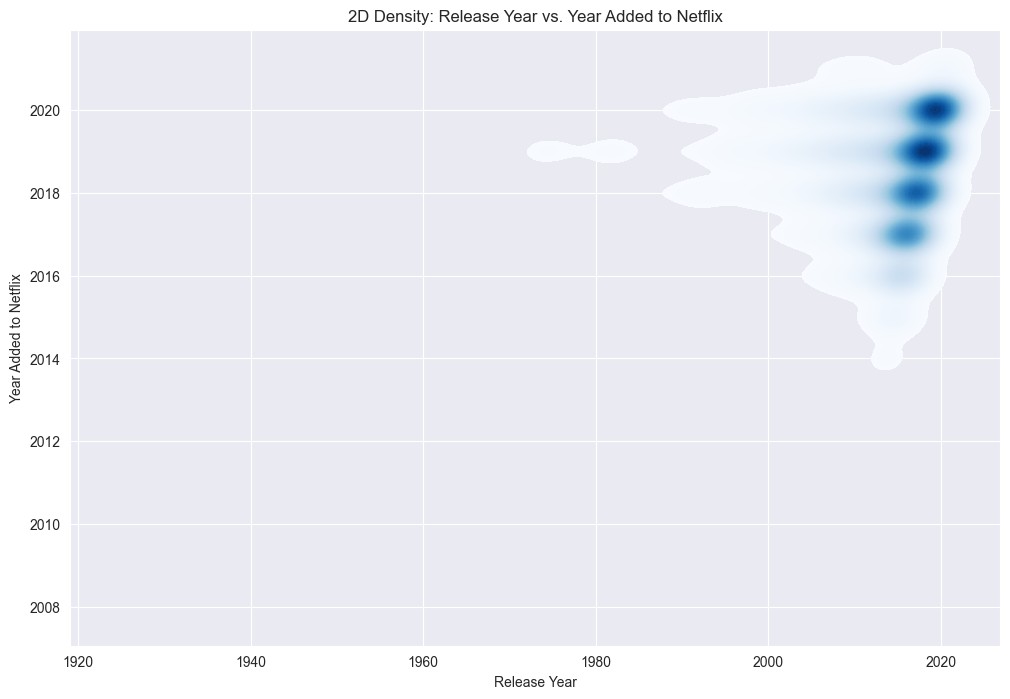

In [57]:
plt.figure(figsize=(12, 8))
sns.kdeplot(
    data=df, x='release_year', y='year_added',
    fill=True, cmap='Blues', thresh=0.05, levels=100
)
plt.xlabel('Release Year')
plt.ylabel('Year Added to Netflix')
plt.title('2D Density: Release Year vs. Year Added to Netflix')
plt.show()

**Insights:**

- The density plot provides a clearer view of content age at addition.
- Most shows and movies added by Netflix were **recently released**.
- Between **2018 and 2020**, Netflix added a higher number of **older shows**.


**4. What are the most common word pairs or phrases in content descriptions?**

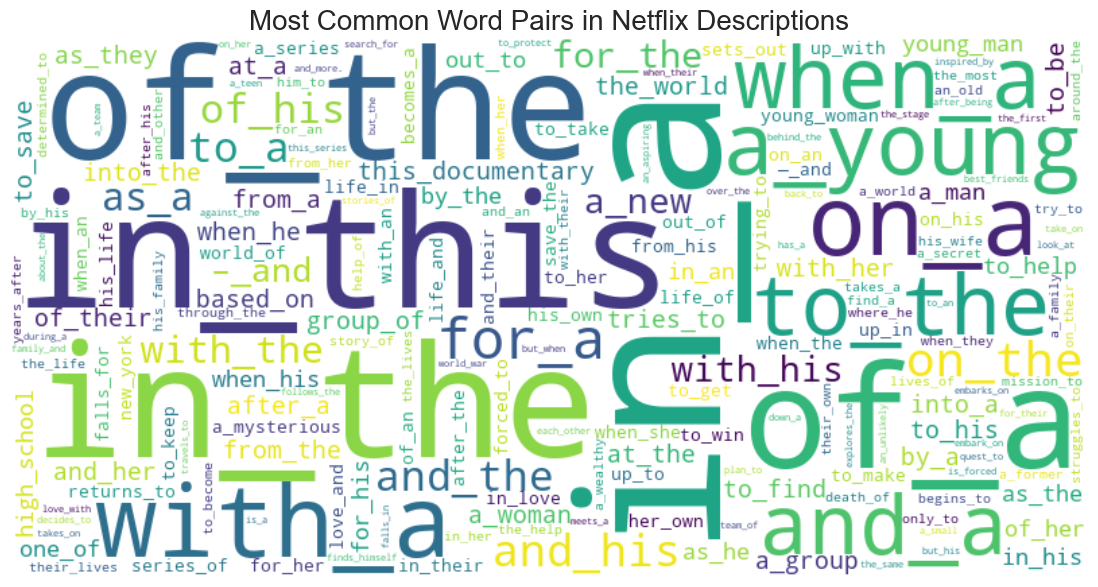

In [66]:
from wordcloud import WordCloud
from collections import Counter

# Prepare bigrams from all descriptions
all_words = ' '.join(df['description'].dropna()).lower().split()
bigrams = ['_'.join([all_words[i], all_words[i+1]]) for i in range(len(all_words)-1)]

# Count bigram frequencies
bigram_counts = Counter(bigrams)

# Generate a word cloud for bigrams
bigram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_counts)

plt.figure(figsize=(15, 7))
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Word Pairs in Netflix Descriptions', fontsize=20)
plt.show()

**Insight:**

- The word cloud reveals frequent word pairs such as **“young_man,” “in_this,” “based_on,” “series_of,” “group_of,” “with_his,” “her_own,”** and **“life_of.”**
- These suggest that Netflix’s descriptions often focus on:
  - **Youthful protagonists**
  - **Personal or family-based storytelling**
  - **Situational or emotional themes**
- The language emphasizes **relatable human experiences** and **narrative-driven plots**, with phrases like:
  - **“based on a true story”**
  - **“young woman”**
  - **“group of friends”**
  - **“mysterious world”**

**5. Who are the top directors on Netflix?**

In [62]:
# Top 10 directors with the most titles on Netflix (excluding 'Unknown')
top_directors = (
    df[df['director'] != 'Unknown']['director']
    .value_counts()
    .head(50)
    .reset_index()
)
top_directors.columns = ['Director', 'Number of Titles']
top_directors

,Director,Number of Titles
0,"Raúl Campos, Jan Suter",18
1,Marcus Raboy,16
2,Jay Karas,14
3,Cathy Garcia-Molina,13
4,Youssef Chahine,12
5,Jay Chapman,12
6,Martin Scorsese,12
7,Steven Spielberg,10
8,David Dhawan,9
9,Quentin Tarantino,8


C:\Users\abhir\AppData\Local\Temp\ipykernel_9704\472112247.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Director', x='Number of Titles', data=top_directors.head(20), palette='flare')


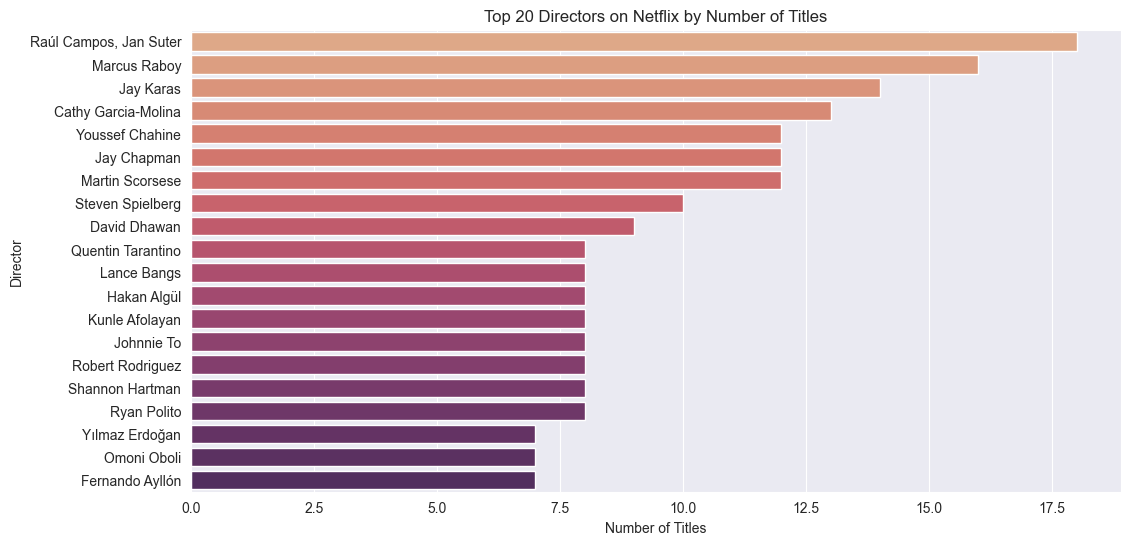

In [63]:
plt.figure(figsize=(12, 6))
sns.barplot(y='Director', x='Number of Titles', data=top_directors.head(20), palette='flare')
plt.title('Top 20 Directors on Netflix by Number of Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Director')
plt.show()

**Answer:**  
The director pair **Raúl Campos** and **Jan Suter** have the most titles. They specialize in Latin American comedy content.  
They are closely followed by **Marcus Raboy** and **Jay Karas**.
